In [113]:
import pandas as pd
from stable_baselines3.common.logger import configure

from finrl.agents.stablebaselines3.models import DRLAgent as StockDRLAgent
from finrl.agents.portfolio_optimization.models import DRLAgent as OptDRLAgent

from finrl.config import TRAINED_MODEL_DIR, RESULTS_DIR
from finrl.main import check_and_make_directories
from finrl.meta.env_stock_trading.env_stocktrading import StockTradingEnv

import numpy as np


TIME_WINDOW = 25
COMMISSION_FEE_PERCENT = 0.001
INITIAL_CASH = 1000000


TEST_START_DATE = '2021-01-01'
TEST_END_DATE = '2024-10-01'

# Backtest the results

from finrl.meta.preprocessor.yahoodownloader import YahooDownloader
from finrl.config_tickers import TEST_TICKER



df = YahooDownloader(start_date = TEST_START_DATE,
                     end_date = TEST_END_DATE,
                     ticker_list = TEST_TICKER).fetch_data()

processed = df.copy()
processed = processed.fillna(0)
processed_test = processed.replace(np.inf,0)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Shape of DataFrame:  (3764, 8)


# Portfolio Optimization Algorithm

In [114]:
from finrl.meta.env_portfolio_optimization.env_portfolio_optimization import PortfolioOptimizationEnv


# Fit for the portfolio optimization model

from sklearn.preprocessing import MaxAbsScaler
from finrl.meta.preprocessor.preprocessors import GroupByScaler

portfolio_norm_df = GroupByScaler(by="tic", scaler=MaxAbsScaler).fit_transform(processed_test)
portfolio_norm_df


environment = PortfolioOptimizationEnv(
    portfolio_norm_df,
    initial_amount=INITIAL_CASH,
    comission_fee_pct=COMMISSION_FEE_PERCENT,
    time_window=TIME_WINDOW,
    features=["close", "high", "low"],
    normalize_df=None
)

c:\Users\bencj\Desktop\Econ4\Thesis\.venv\lib\site-packages\finrl\meta\preprocessor\preprocessors.py:101: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.44967348 0.30646708 0.48665761 0.34385037 0.32998065 0.31500104
 0.28853749 0.2781374  0.28311105 0.35018996 0.28479142 0.32734885
 0.37702692 0.3591673  0.49457685 0.30874429 0.4419601  0.44753717
 0.55705992 0.33337465 0.26140776 0.28204132 0.26416194 0.23752298
 0.22372669 0.24091322 0.22921621 0.2017071  0.18873202 0.252844
 0.30726287 0.303931   0.27509987 0.32608395 0.49665197 0.3484371
 0.46504188 0.51638148 0.36496779 0.32088908 0.35448204 0.55904059
 0.48251113 0.48442528 0.40644484 0.35127192 0.32329149 0.27646896
 0.28995804 0.36157881 0.35123834 0.38041213 0.58224413 0.35117464
 0.29957051 0.27780384 0.31016923 0.29519025 0.2536062  0.26883371
 0.37129358 0.23562547 0.27818259 0.25157313 0.26191391 0.27878947
 0.334777   0.28687093 0.286389

In [115]:
import torch
from finrl.agents.portfolio_optimization.architectures import EIIE

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

# set PolicyGradient parameters
model_kwargs = {
    "lr": 0.01,
    "policy": EIIE,
}

# here, we can set EIIE's parameters
policy_kwargs = {
    "k_size": 3,
    "time_window": TIME_WINDOW,
}


# instantiate an architecture with the same arguments used in training
# and load with load_state_dict.
policy = EIIE(time_window=TIME_WINDOW, device=device)
policy.load_state_dict(torch.load("policy_EIIE.pt"))

C:\Users\bencj\AppData\Local\Temp\ipykernel_27176\3962532677.py:22: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  policy.load_state_dict(torch.load("policy_EIIE.pt"))


<All keys matched successfully>

In [116]:
EIIE_results = {
    "20212024": {},
}

# 2021 - 2024
# Initialize the model
model = OptDRLAgent(environment).get_model("pg", device, model_kwargs, policy_kwargs)
OptDRLAgent.DRL_validation(model, environment, policy=policy)
EIIE_results["20212024"]["value"] = environment._asset_memory["final"]
EIIE_results["20212024"]["date"] = environment._date_memory



# Write this out to a csv file, with date and net worth
df_opt = pd.DataFrame(EIIE_results["20212024"]["value"], columns=['opt_net_worth'])
df_date = pd.DataFrame(EIIE_results["20212024"]["date"], columns=['Date'])
if len(df_opt) == len(df_date):
    df_opt['Date'] = df_date['Date']
else:
    raise ValueError("DataFrames do not have the same number of rows.")


# The optimization algoirhtm has a shorter window than the full df, so shorted this for the follow algorithm
opt_start = df_opt.loc[0,'Date']


Initial portfolio value:1000000
Final portfolio value: 1538984.875
Final accumulative portfolio value: 1.538984875
Maximum DrawDown: -0.2500596655676266
Sharpe ratio: 0.6884961070154527
Total commission cost: 10501.965351916617


In [117]:
print(df_opt)

     opt_net_worth       Date
0     1.000000e+06 2021-02-08
1     9.985688e+05 2021-02-09
2     9.986730e+05 2021-02-10
3     9.951045e+05 2021-02-11
4     1.000757e+06 2021-02-12
..             ...        ...
912   1.541509e+06 2024-09-24
913   1.509838e+06 2024-09-25
914   1.527915e+06 2024-09-26
915   1.541078e+06 2024-09-27
916   1.538985e+06 2024-09-30

[917 rows x 2 columns]


In [118]:
opt_end = df_opt.loc[len(df_date)-1,'Date']

print(opt_start)
opt_start = opt_start.strftime('%Y-%m-%d %H:%M:%S')


print(opt_end)
opt_end = opt_end.strftime('%Y-%m-%d %H:%M:%S')

2021-02-08 00:00:00
2024-09-30 00:00:00


# PPO On portfolio Opt

In [ ]:

# Fit for the portfolio optimization model

from sklearn.preprocessing import MaxAbsScaler
from finrl.meta.preprocessor.preprocessors import GroupByScaler

from finrl.meta.preprocessor.preprocessors import data_split

from datetime import datetime, timedelta
# Make sure dates line up, TODO fix this for real dates
# Make sure we only test on the same data as the portfolio optimization algorithm
# Convert to datetime
opt_start_date = datetime.strptime(opt_start, '%Y-%m-%d %H:%M:%S')

# Subtract one day
new_opt_start_date = opt_start_date - timedelta(days=1)

# Convert back to string
new_opt_start_str = new_opt_start_date.strftime('%Y-%m-%d %H:%M:%S')

test = data_split(portfolio_norm_df, new_opt_start_str,opt_end)


portfolio_norm_df = GroupByScaler(by="tic", scaler=MaxAbsScaler).fit_transform(test)
portfolio_norm_df


environment_ppo = PortfolioOptimizationEnv(
    portfolio_norm_df,
    initial_amount=INITIAL_CASH,
    comission_fee_pct=COMMISSION_FEE_PERCENT,
    # time_window=TIME_WINDOW,
    features=["close", "high", "low"],
    normalize_df=None,
    reward_scaling=1e-4
)

In [120]:
from stable_baselines3 import PPO
from finrl.config import TRAINED_MODEL_DIR


# Load the trained models
trained_ppo_opt = PPO.load(TRAINED_MODEL_DIR + "/agent_opt_ppo") 

In [ ]:
from finrl.agents.portfolio_optimization.models_stable import DRLStableAgent

PPO_results = {
    "20212024": {},
}

values, dates = DRLStableAgent.DRL_prediction(trained_ppo_opt, environment_ppo, deterministic=True)
PPO_results["20212024"]["value"] = environment_ppo._terminal_asset_memory["final"]
PPO_results["20212024"]["date"] = environment_ppo._terminal_date_memory


# Write this out to a csv file, with date and net worth
df_ppo_opt = pd.DataFrame(PPO_results["20212024"]["value"], columns=['ppo_opt_net_worth'])
df_ppo_date = pd.DataFrame(PPO_results["20212024"]["date"], columns=['Date'])
if len(df_ppo_opt) == len(df_ppo_date):
    df_ppo_opt['Date'] = df_ppo_date['Date']
else:
    raise ValueError("DataFrames do not have the same number of rows.")

print(df_ppo_opt)


# assert the dates line up
assert df_opt.loc[0,'Date'] == df_ppo_opt.loc[0, 'Date']
assert df_opt.loc[len(df_date)-1,'Date'] == df_ppo_opt.loc[len(df_ppo_opt)-1,'Date']

c:\Users\bencj\Desktop\Econ4\Thesis\.venv\lib\site-packages\stable_baselines3\common\vec_env\patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


Initial portfolio value:1000000
Final portfolio value: 1428563.75
Final accumulative portfolio value: 1.42856375
Maximum DrawDown: -0.20332458836708056
Sharpe ratio: 0.6883279154152534
Total commission cost: 8292.908194866031
hit end!
     ppo_opt_net_worth       Date
0         1.000000e+06 2021-02-08
1         9.988549e+05 2021-02-09
2         9.989384e+05 2021-02-10
3         9.960826e+05 2021-02-11
4         1.000610e+06 2021-02-12
..                 ...        ...
912       1.430363e+06 2024-09-24
913       1.406854e+06 2024-09-25
914       1.420334e+06 2024-09-26
915       1.430120e+06 2024-09-27
916       1.428564e+06 2024-09-30

[917 rows x 2 columns]


In [123]:
trained_ppo_opt_2 = PPO.load(TRAINED_MODEL_DIR + "/agent_opt_ppo_test_2020_1110") 

PPO_results_2 = {
    "20212024": {},
}

environment_ppo.reset()
values, dates = DRLStableAgent.DRL_prediction(trained_ppo_opt_2, environment_ppo, deterministic=True)
PPO_results_2["20212024"]["value"] = environment_ppo._terminal_asset_memory["final"]
PPO_results_2["20212024"]["date"] = environment_ppo._terminal_date_memory


# Write this out to a csv file, with date and net worth
df_ppo_opt_2 = pd.DataFrame(PPO_results_2["20212024"]["value"], columns=['ppo_opt_net_worth_2'])
df_ppo_date_2 = pd.DataFrame(PPO_results_2["20212024"]["date"], columns=['Date'])
if len(df_ppo_opt_2) == len(df_ppo_date_2):
    df_ppo_opt_2['Date'] = df_ppo_date_2['Date']
else:
    raise ValueError("DataFrames do not have the same number of rows.")

print(df_ppo_opt_2)


# assert the dates line up
assert df_opt.loc[0,'Date'] == df_ppo_opt_2.loc[0, 'Date']
assert df_opt.loc[len(df_date)-1,'Date'] == df_ppo_opt_2.loc[len(df_ppo_opt_2)-1,'Date']

c:\Users\bencj\Desktop\Econ4\Thesis\.venv\lib\site-packages\stable_baselines3\common\vec_env\patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


Initial portfolio value:1000000
Final portfolio value: 1397669.875
Final accumulative portfolio value: 1.397669875
Maximum DrawDown: -0.2739624823628678
Sharpe ratio: 0.549817547811149
Total commission cost: 8829.969392272411
hit end!
     ppo_opt_net_worth_2       Date
0            1000000.000 2021-02-08
1            1000283.000 2021-02-09
2             999789.125 2021-02-10
3             997006.000 2021-02-11
4            1002072.250 2021-02-12
..                   ...        ...
912          1400278.375 2024-09-24
913          1380024.125 2024-09-25
914          1394302.625 2024-09-26
915          1406272.125 2024-09-27
916          1397669.875 2024-09-30

[917 rows x 2 columns]


# Porfolio Baselines

In [124]:
# CRP 

CRP_results = {
    "20212024": {},
}

environment_ppo.reset()
agent_crp = DRLStableAgent(env = environment_ppo)
model_crp = agent_crp.get_model("crp", None, None)

values, dates = DRLStableAgent.DRL_prediction(model_crp, environment_ppo)
CRP_results["20212024"]["value"] = environment_ppo._terminal_asset_memory["final"]
CRP_results["20212024"]["date"] = environment_ppo._terminal_date_memory

df_crp_opt = pd.DataFrame(CRP_results["20212024"]["value"], columns=['crp_opt_net_worth'])
df_crp_date = pd.DataFrame(CRP_results["20212024"]["date"], columns=['Date'])
if len(df_crp_opt) == len(df_crp_date):
    df_crp_opt['Date'] = df_crp_date['Date']
else:
    raise ValueError("DataFrames do not have the same number of rows.")

print(df_crp_opt)


# assert the dates line up
assert df_opt.loc[0,'Date'] == df_crp_opt.loc[0, 'Date']
assert df_opt.loc[len(df_date)-1,'Date'] == df_crp_opt.loc[len(df_crp_opt)-1,'Date']

c:\Users\bencj\Desktop\Econ4\Thesis\.venv\lib\site-packages\stable_baselines3\common\vec_env\patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


Initial portfolio value:1000000
Final portfolio value: 1539008.0
Final accumulative portfolio value: 1.539008
Maximum DrawDown: -0.2500666587249277
Sharpe ratio: 0.6884978742393338
Total commission cost: 10502.577418961562
hit end!
     crp_opt_net_worth       Date
0         1.000000e+06 2021-02-08
1         9.985686e+05 2021-02-09
2         9.986729e+05 2021-02-10
3         9.951040e+05 2021-02-11
4         1.000757e+06 2021-02-12
..                 ...        ...
912       1.541532e+06 2024-09-24
913       1.509860e+06 2024-09-25
914       1.527938e+06 2024-09-26
915       1.541101e+06 2024-09-27
916       1.539008e+06 2024-09-30

[917 rows x 2 columns]


In [125]:
# BAH

BAH_results = {
    "20212024": {},
}

environment_ppo.reset()
agent_bah = DRLStableAgent(env = environment_ppo)
model_bah = agent_bah.get_model("bah", None, None)

values, dates = DRLStableAgent.DRL_prediction(model_bah, environment_ppo)
BAH_results["20212024"]["value"] = environment_ppo._terminal_asset_memory["final"]
BAH_results["20212024"]["date"] = environment_ppo._terminal_date_memory

df_bah_opt = pd.DataFrame(BAH_results["20212024"]["value"], columns=['bah_opt_net_worth'])
df_bah_date = pd.DataFrame(BAH_results["20212024"]["date"], columns=['Date'])
if len(df_bah_opt) == len(df_bah_date):
    df_bah_opt['Date'] = df_bah_date['Date']
else:
    raise ValueError("DataFrames do not have the same number of rows.")

print(df_bah_opt)


# assert the dates line up
assert df_opt.loc[0,'Date'] == df_bah_opt.loc[0, 'Date']
assert df_opt.loc[len(df_date)-1,'Date'] == df_bah_opt.loc[len(df_bah_opt)-1,'Date']

[0.   0.25 0.25 0.25 0.25]


c:\Users\bencj\Desktop\Econ4\Thesis\.venv\lib\site-packages\stable_baselines3\common\vec_env\patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


Initial portfolio value:1000000
Final portfolio value: 1548712.75
Final accumulative portfolio value: 1.54871275
Maximum DrawDown: -0.251290563636542
Sharpe ratio: 0.7051884933625756
Total commission cost: 0.0
hit end!
     bah_opt_net_worth       Date
0         1.000000e+06 2021-02-08
1         9.985686e+05 2021-02-09
2         9.985944e+05 2021-02-10
3         9.950298e+05 2021-02-11
4         1.000705e+06 2021-02-12
..                 ...        ...
912       1.542786e+06 2024-09-24
913       1.515234e+06 2024-09-25
914       1.531590e+06 2024-09-26
915       1.544316e+06 2024-09-27
916       1.548713e+06 2024-09-30

[917 rows x 2 columns]


In [126]:
# OLMAR

OLMAR_results = {
    "20212024": {},
}

# OLMAR_model_kwargs = {
#     "eps": 60,
#     "window": 100
# }


environment_ppo.reset()
agent_olmar = DRLStableAgent(env = environment_ppo)
model_olmar = agent_olmar.get_model("olmar", model_kwargs=None)

values, dates = DRLStableAgent.DRL_prediction(model_olmar, environment_ppo)
OLMAR_results["20212024"]["value"] = environment_ppo._terminal_asset_memory["final"]
OLMAR_results["20212024"]["date"] = environment_ppo._terminal_date_memory

df_olmar_opt = pd.DataFrame(OLMAR_results["20212024"]["value"], columns=['olmar_opt_net_worth'])
df_olmar_date = pd.DataFrame(OLMAR_results["20212024"]["date"], columns=['Date'])
if len(df_olmar_opt) == len(df_olmar_date):
    df_olmar_opt['Date'] = df_olmar_date['Date']
else:
    raise ValueError("DataFrames do not have the same number of rows.")

print(df_olmar_opt)


# assert the dates line up
assert df_opt.loc[0,'Date'] == df_olmar_opt.loc[0, 'Date']
assert df_opt.loc[len(df_date)-1,'Date'] == df_olmar_opt.loc[len(df_olmar_opt)-1,'Date']

c:\Users\bencj\Desktop\Econ4\Thesis\.venv\lib\site-packages\stable_baselines3\common\vec_env\patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


Initial portfolio value:1000000
Final portfolio value: 406772.5625
Final accumulative portfolio value: 0.4067725625
Maximum DrawDown: -0.6469144375
Sharpe ratio: -0.6441482480457699
Total commission cost: 440147.14616354066
hit end!
     olmar_opt_net_worth       Date
0          1000000.00000 2021-02-08
1           998568.62500 2021-02-09
2           982247.68750 2021-02-10
3           973409.18750 2021-02-11
4           981381.62500 2021-02-12
..                   ...        ...
912         417768.40625 2024-09-24
913         394968.62500 2024-09-25
914         402846.34375 2024-09-26
915         407353.31250 2024-09-27
916         406772.56250 2024-09-30

[917 rows x 2 columns]


In [127]:
# RMR

RMR_results = {
    "20212024": {},
}

# RMR_model_kwargs = {
#     "eps": 60,
#     "window": 100
# }

environment_ppo.reset()
agent_rmr = DRLStableAgent(env = environment_ppo)
model_rmr = agent_rmr.get_model("rmr", model_kwargs=None)

values, dates = DRLStableAgent.DRL_prediction(model_rmr, environment_ppo)
RMR_results["20212024"]["value"] = environment_ppo._terminal_asset_memory["final"]
RMR_results["20212024"]["date"] = environment_ppo._terminal_date_memory

df_rmr_opt = pd.DataFrame(RMR_results["20212024"]["value"], columns=['rmr_opt_net_worth'])
df_rmr_date = pd.DataFrame(RMR_results["20212024"]["date"], columns=['Date'])
if len(df_rmr_opt) == len(df_rmr_date):
    df_rmr_opt['Date'] = df_rmr_date['Date']
else:
    raise ValueError("DataFrames do not have the same number of rows.")

print(df_rmr_opt)


# assert the dates line up
assert df_opt.loc[0,'Date'] == df_rmr_opt.loc[0, 'Date']
assert df_opt.loc[len(df_date)-1,'Date'] == df_rmr_opt.loc[len(df_rmr_opt)-1,'Date']

c:\Users\bencj\Desktop\Econ4\Thesis\.venv\lib\site-packages\stable_baselines3\common\vec_env\patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


Initial portfolio value:1000000
Final portfolio value: 1398112.25
Final accumulative portfolio value: 1.39811225
Maximum DrawDown: -0.36768460586191765
Sharpe ratio: 0.4673592848868623
Total commission cost: 33539.97159635322
hit end!
     rmr_opt_net_worth       Date
0         1.000000e+06 2021-02-08
1         9.985686e+05 2021-02-09
2         9.822477e+05 2021-02-10
3         9.734092e+05 2021-02-11
4         9.813816e+05 2021-02-12
..                 ...        ...
912       1.372387e+06 2024-09-24
913       1.372181e+06 2024-09-25
914       1.382389e+06 2024-09-26
915       1.397390e+06 2024-09-27
916       1.398112e+06 2024-09-30

[917 rows x 2 columns]


In [128]:
# BNN

BNN_results = {
    "20212024": {},
}

# RMR_model_kwargs = {
#     "eps": 60,
#     "window": 100
# }

environment_ppo.reset()
agent_bnn = DRLStableAgent(env = environment_ppo)
model_bnn = agent_bnn.get_model("bnn", model_kwargs=None)

values, dates = DRLStableAgent.DRL_prediction(model_bnn, environment_ppo)
BNN_results["20212024"]["value"] = environment_ppo._terminal_asset_memory["final"]
BNN_results["20212024"]["date"] = environment_ppo._terminal_date_memory

df_bnn_opt = pd.DataFrame(BNN_results["20212024"]["value"], columns=['bnn_opt_net_worth'])
df_bnn_date = pd.DataFrame(BNN_results["20212024"]["date"], columns=['Date'])
if len(df_bnn_opt) == len(df_bnn_date):
    df_bnn_opt['Date'] = df_bnn_date['Date']
else:
    raise ValueError("DataFrames do not have the same number of rows.")

print(df_bnn_opt)


# assert the dates line up
assert df_opt.loc[0,'Date'] == df_bnn_opt.loc[0, 'Date']
assert df_opt.loc[len(df_date)-1,'Date'] == df_bnn_opt.loc[len(df_bnn_opt)-1,'Date']

c:\Users\bencj\Desktop\Econ4\Thesis\.venv\lib\site-packages\stable_baselines3\common\vec_env\patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


Initial portfolio value:1000000
Final portfolio value: 1379316.125
Final accumulative portfolio value: 1.379316125
Maximum DrawDown: -0.3484785006571377
Sharpe ratio: 0.4551172230116083
Total commission cost: 35825.021271565696
hit end!
     bnn_opt_net_worth       Date
0          1000000.000 2021-02-08
1          1000000.000 2021-02-09
2          1000000.000 2021-02-10
3          1000000.000 2021-02-11
4          1000000.000 2021-02-12
..                 ...        ...
912        1353937.125 2024-09-24
913        1353733.750 2024-09-25
914        1363803.875 2024-09-26
915        1378604.000 2024-09-27
916        1379316.125 2024-09-30

[917 rows x 2 columns]


# Try BCRP extreme, which is the absolute best portfolio over the period with hindsight


In [129]:
# bcrp

BCRP_results = {
    "20212024": {},
}

environment_ppo.reset()
agent_bcrp= DRLStableAgent(env = environment_ppo)
model_bcrp= agent_bcrp.get_model("bcrp", None, None)

values, dates = DRLStableAgent.DRL_prediction(model_bcrp, environment_ppo)
BCRP_results["20212024"]["value"] = environment_ppo._terminal_asset_memory["final"]
BCRP_results["20212024"]["date"] = environment_ppo._terminal_date_memory

df_bcrp_opt = pd.DataFrame(BCRP_results["20212024"]["value"], columns=['bcrp_opt_net_worth'])
df_bcrp_date = pd.DataFrame(BCRP_results["20212024"]["date"], columns=['Date'])
if len(df_bcrp_opt) == len(df_bcrp_date):
    df_bcrp_opt['Date'] = df_bcrp_date['Date']
else:
    raise ValueError("DataFrames do not have the same number of rows.")

print(df_bcrp_opt)


# assert the dates line up
assert df_opt.loc[0,'Date'] == df_bcrp_opt.loc[0, 'Date']
assert df_opt.loc[len(df_date)-1,'Date'] == df_bcrp_opt.loc[len(df_bcrp_opt)-1,'Date']

c:\Users\bencj\Desktop\Econ4\Thesis\.venv\lib\site-packages\stable_baselines3\common\vec_env\patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


Initial portfolio value:1000000
Final portfolio value: 2216338.5
Final accumulative portfolio value: 2.2163385
Maximum DrawDown: -0.3154592279363182
Sharpe ratio: 0.9061665547585647
Total commission cost: 5.7014403864741325e-05
hit end!
     bcrp_opt_net_worth       Date
0          1.000000e+06 2021-02-08
1          9.897649e+05 2021-02-09
2          1.001875e+06 2021-02-10
3          1.002500e+06 2021-02-11
4          1.012735e+06 2021-02-12
..                  ...        ...
912        2.175558e+06 2024-09-24
913        2.175232e+06 2024-09-25
914        2.191413e+06 2024-09-26
915        2.215194e+06 2024-09-27
916        2.216338e+06 2024-09-30

[917 rows x 2 columns]


# Stock environment optimization algorithm

In [130]:
# from finrl.meta.preprocessor.preprocessors import data_split

# Make sure we only test on the same data as the portfolio optimization algorithm
# test = data_split(test, opt_start,opt_end)


In [131]:
# from stable_baselines3 import PPO, TD3, A2C
# from finrl.config import TRAINED_MODEL_DIR


# # Load the trained models
# trained_ppo = PPO.load(TRAINED_MODEL_DIR + "/agent_ppo") 

# trained_td3 = TD3.load(TRAINED_MODEL_DIR + "/agent_td3") 

# trained_a2c = A2C.load(TRAINED_MODEL_DIR + "/agent_a2c") 

In [132]:
# # Test out of sample performance

# stock_dimension = len(test.tic.unique())
# state_space = 1 + 2 * stock_dimension + len(INDICATORS) * stock_dimension
# print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")

In [133]:
# buy_cost_list = sell_cost_list = [COMMISSION_FEE_PERCENT] * stock_dimension
# num_stock_shares = [0] * stock_dimension

# env_kwargs = {
#     "hmax": 100,
#     "initial_amount": INITIAL_CASH,
#     "num_stock_shares": num_stock_shares,
#     "buy_cost_pct": buy_cost_list,
#     "sell_cost_pct": sell_cost_list,
#     "state_space": state_space,
#     "stock_dim": stock_dimension,
#     "tech_indicator_list": INDICATORS,
#     "action_space": stock_dimension,
#     "reward_scaling": 1e-4
# }

In [134]:
# e_trade_gym_ppo = StockTradingEnv(df = test, turbulence_threshold = 70, **env_kwargs)

# df_account_value_ppo, df_actions_ppo = StockDRLAgent.DRL_prediction(
#     model=trained_ppo, 
#     environment = e_trade_gym_ppo,
#     deterministic=True)

In [135]:
# df_account_value_ppo.rename(columns={'date': 'Date', 'account_value' : "ppo_value"}, inplace=True)
# df_account_value_ppo

In [136]:
# e_trade_gym_td3 = StockTradingEnv(df = test, turbulence_threshold = 70, **env_kwargs)

# df_account_value_td3, df_actions_td3 = StockDRLAgent.DRL_prediction(
#     model=trained_td3, 
#     environment = e_trade_gym_td3)

In [137]:
# df_account_value_td3.rename(columns={'date': 'Date', 'account_value' : "td3_value"}, inplace=True)
# df_account_value_td3

In [138]:

# e_trade_gym_a2c = StockTradingEnv(df = test, turbulence_threshold = 70, **env_kwargs)

# df_account_value_a2c, df_actions_a2c = StockDRLAgent.DRL_prediction(
#     model=trained_a2c, 
#     environment = e_trade_gym_a2c)

# df_account_value_a2c.rename(columns={'date': 'Date', 'account_value' : "a2c_value"}, inplace=True)
# df_account_value_a2c

In [139]:
# Pull the DJI results

from finrl.plot import backtest_stats, backtest_plot, get_daily_return, get_baseline


df_dji_ = get_baseline(
        ticker="^DJI",
        start = df_date.loc[0,'Date'],
        end = df_date.loc[len(df_date)-1,'Date'])

stats = backtest_stats(df_dji_, value_col_name = 'close')

df_dji = pd.DataFrame()
df_dji['date'] = df_date['Date']
df_dji['dji'] = df_dji_['close'] / df_dji_['close'][0] * INITIAL_CASH
print("df_dji: ", df_dji)
df_dji.to_csv("df_dji.csv")
df_dji = df_dji.set_index(df_dji.columns[0])
print("df_dji: ", df_dji)


[*********************100%***********************]  1 of 1 completed

Shape of DataFrame:  (916, 8)
Annual return          0.085658
Cumulative returns     0.348159
Annual volatility      0.142850
Sharpe ratio           0.647472
Calmar ratio           0.390404
Stability              0.338388
Max drawdown          -0.219408
Omega ratio            1.116763
Sortino ratio          0.923348
Skew                        NaN
Kurtosis                    NaN
Tail ratio             0.989221
Daily value at risk   -0.017630
dtype: float64
df_dji:            date           dji
0   2021-02-08  1.000000e+06
1   2021-02-09  9.996836e+05
2   2021-02-10  1.001658e+06
3   2021-02-11  1.001432e+06
4   2021-02-12  1.002314e+06
..         ...           ...
912 2024-09-24  1.344821e+06
913 2024-09-25  1.335470e+06
914 2024-09-26  1.343766e+06
915 2024-09-27  1.348159e+06
916 2024-09-30           NaN

[917 rows x 2 columns]
df_dji:                       dji
date                    
2021-02-08  1.000000e+06
2021-02-09  9.996836e+05
2021-02-10  1.001658e+06
2021-02-11  1.001432e+06

# Compare all results

In [141]:
# Join the online algorithms

# bcrp = pd.read_csv('BCRP_net_worth.csv')
# crp = pd.read_csv('CRP_net_worth.csv')


# Merge the baseline CRP algorithm
df_crp_opt['Date'] = pd.to_datetime(df_crp_opt['Date'])
merged_df = df_crp_opt

# Merge the baseline BCRP algorithm
df_bcrp_opt['Date'] = pd.to_datetime(df_bcrp_opt['Date'])
merged_df = pd.merge(merged_df, df_bcrp_opt, on='Date')

# Merge the baseline BAH algorithm
df_bah_opt['Date'] = pd.to_datetime(df_bah_opt['Date'])
merged_df = pd.merge(merged_df, df_bah_opt, on='Date')

# Merge the baseline OLMAR algorithm
df_olmar_opt['Date'] = pd.to_datetime(df_olmar_opt['Date'])
merged_df = pd.merge(merged_df, df_olmar_opt, on='Date')

# Merge the baseline RMR algorithm
df_rmr_opt['Date'] = pd.to_datetime(df_rmr_opt['Date'])
merged_df = pd.merge(merged_df, df_rmr_opt, on='Date')

# Merge the baseline BNN algorithm
df_bnn_opt['Date'] = pd.to_datetime(df_bnn_opt['Date'])
merged_df = pd.merge(merged_df, df_bnn_opt, on='Date')

# Merge the opt algorithm
df_opt['Date'] = pd.to_datetime(df_opt['Date'])
merged_df = pd.merge(merged_df, df_opt, on='Date')

# Merge the PPO opt algorithm
df_ppo_opt['Date'] = pd.to_datetime(df_ppo_opt['Date'])
merged_df = pd.merge(merged_df, df_ppo_opt, on='Date')

# Merge the PPO opt algorithm 2
df_ppo_opt_2['Date'] = pd.to_datetime(df_ppo_opt_2['Date'])
merged_df = pd.merge(merged_df, df_ppo_opt_2, on='Date')





print(df_dji)
df_dji = df_dji.reset_index()
df_dji.rename(columns={'date': 'Date'}, inplace=True)
merged_df = pd.merge(merged_df, df_dji, on='Date')


print(merged_df)


                     dji
date                    
2021-02-08  1.000000e+06
2021-02-09  9.996836e+05
2021-02-10  1.001658e+06
2021-02-11  1.001432e+06
2021-02-12  1.002314e+06
...                  ...
2024-09-24  1.344821e+06
2024-09-25  1.335470e+06
2024-09-26  1.343766e+06
2024-09-27  1.348159e+06
2024-09-30           NaN

[917 rows x 1 columns]
     crp_opt_net_worth       Date  bcrp_opt_net_worth  bah_opt_net_worth  \
0         1.000000e+06 2021-02-08        1.000000e+06       1.000000e+06   
1         9.985686e+05 2021-02-09        9.897649e+05       9.985686e+05   
2         9.986729e+05 2021-02-10        1.001875e+06       9.985944e+05   
3         9.951040e+05 2021-02-11        1.002500e+06       9.950298e+05   
4         1.000757e+06 2021-02-12        1.012735e+06       1.000705e+06   
..                 ...        ...                 ...                ...   
912       1.541532e+06 2024-09-24        2.175558e+06       1.542786e+06   
913       1.509860e+06 2024-09-25        2.

# Baseline CRP in the environment

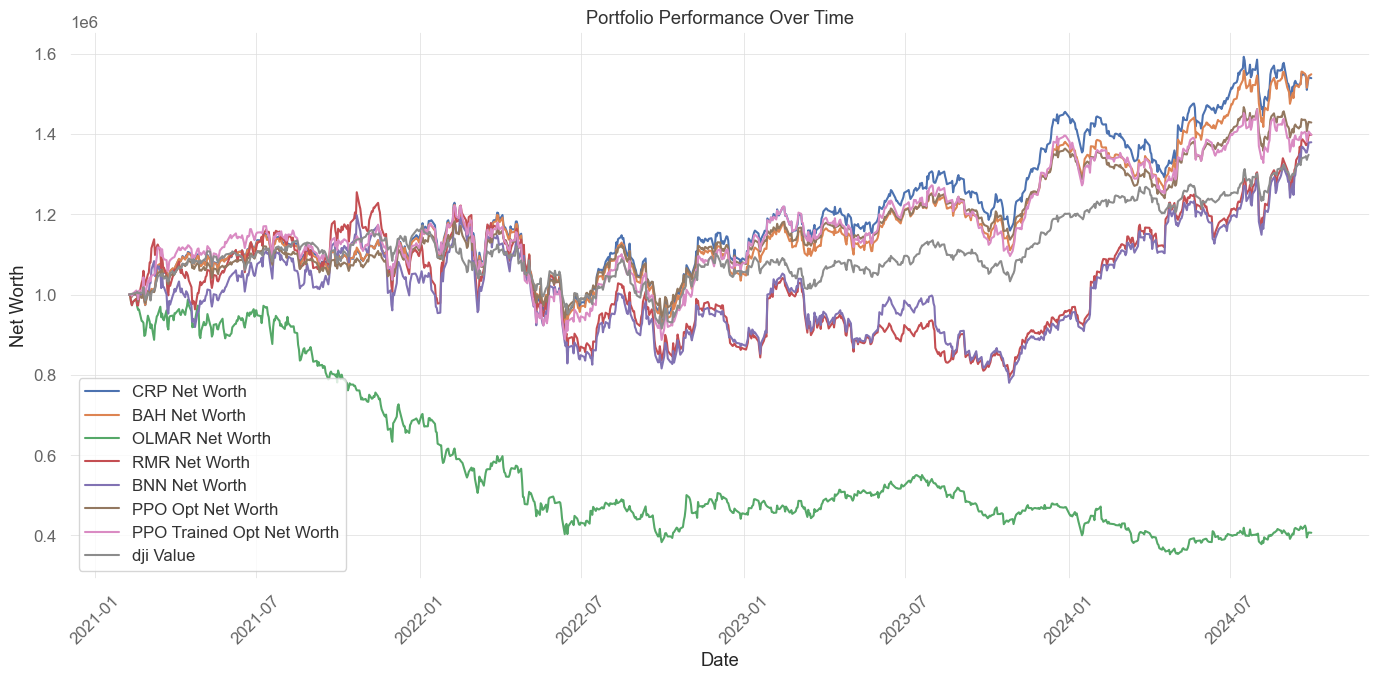

In [142]:
# Use the correct backend for Jupyter
%matplotlib inline
import matplotlib.pyplot as plt

# TODO make sure all dates line up, fix CRP and OLMAR 

# Plot the DataFrame
plt.figure(figsize=(14, 7))
# plt.plot(merged_df['Date'], merged_df['bcrp_opt_net_worth'], label='BCRP Net Worth')
# plt.plot(merged_df['Date'], merged_df['CRP_net_worth'], label='CRP Net Worth')# CRP and Opt net worth are basically on the same line
plt.plot(merged_df['Date'], merged_df['crp_opt_net_worth'], label='CRP Net Worth')
plt.plot(merged_df['Date'], merged_df['bah_opt_net_worth'], label='BAH Net Worth')
plt.plot(merged_df['Date'], merged_df['olmar_opt_net_worth'], label='OLMAR Net Worth')
plt.plot(merged_df['Date'], merged_df['rmr_opt_net_worth'], label='RMR Net Worth')
plt.plot(merged_df['Date'], merged_df['bnn_opt_net_worth'], label='BNN Net Worth')


# plt.plot(merged_df['Date'], merged_df['opt_net_worth'], label='Opt Net Worth')
plt.plot(merged_df['Date'], merged_df['ppo_opt_net_worth'], label='PPO Opt Net Worth')
plt.plot(merged_df['Date'], merged_df['ppo_opt_net_worth_2'], label='PPO Trained Opt Net Worth')
# plt.plot(merged_df['Date'], merged_df['ppo_value'], label='PPO Value')
# plt.plot(merged_df['Date'], merged_df['td3_value'], label='TD3 Value')
# plt.plot(merged_df['Date'], merged_df['a2c_value'], label='A2C Value')
plt.plot(merged_df['Date'], merged_df['dji'], label='dji Value')
plt.xlabel('Date')
plt.ylabel('Net Worth')
plt.title('Portfolio Performance Over Time')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

In [144]:
import pprint

final_returns = {
   'BCRP OPT': merged_df['bcrp_opt_net_worth'].iloc[-1],
    'CRP': merged_df['crp_opt_net_worth'].iloc[-1],
    'BAH': merged_df['bah_opt_net_worth'].iloc[-1],
    'OLMAR': merged_df['olmar_opt_net_worth'].iloc[-1],
    'RMR': merged_df['rmr_opt_net_worth'].iloc[-1],
    'BNN': merged_df['bnn_opt_net_worth'].iloc[-1],
   'PPO': merged_df['ppo_opt_net_worth'].iloc[-1],
   'PPO Trained': merged_df['ppo_opt_net_worth_2'].iloc[-1]
}

pprint.pprint(final_returns)

{'BAH': 1548712.75,
 'BCRP OPT': 2216338.5,
 'BNN': 1379316.125,
 'CRP': 1539008.0,
 'OLMAR': 406772.5625,
 'PPO': 1428563.75,
 'PPO Trained': 1397669.875,
 'RMR': 1398112.25}


In [145]:
import numpy as np
import pprint

# Calculate the returns each day

# merged_df['BCRP_daily_return'] = merged_df['BCRP_net_worth'].pct_change()
# merged_df['CRP_daily_return'] = merged_df['CRP_net_worth'].pct_change()
merged_df['BCRP_opt_daily_return'] = merged_df['bcrp_opt_net_worth'].pct_change()
merged_df['CRP_opt_daily_return'] = merged_df['crp_opt_net_worth'].pct_change()
merged_df['BAH_opt_daily_return'] = merged_df['bah_opt_net_worth'].pct_change()
merged_df['OLMAR_opt_daily_return'] = merged_df['olmar_opt_net_worth'].pct_change()
merged_df['RMR_opt_daily_return'] = merged_df['rmr_opt_net_worth'].pct_change()
merged_df['BNN_opt_daily_return'] = merged_df['bnn_opt_net_worth'].pct_change()


# merged_df['OLMAR_daily_return'] = merged_df['OLMAR_net_worth'].pct_change()
merged_df['opt_daily_return'] = merged_df['opt_net_worth'].pct_change()
merged_df['ppo_opt_daily_return'] = merged_df['ppo_opt_net_worth'].pct_change()
merged_df['ppo_opt_daily_return_2'] = merged_df['ppo_opt_net_worth_2'].pct_change()

# TODO need to put in the fama french

# Define the risk-free rate (annual, for example, 2%)
risk_free_rate = 0.02 / 252  # Convert annual risk-free rate to daily

# Define a function to calculate Sharpe ratio adjusted for the risk-free rate
def calculate_sharpe_ratio(returns, risk_free_rate):
    excess_return = returns - risk_free_rate
    mean_excess_return = excess_return.mean()
    std_excess_return = excess_return.std()
    annual_factor = np.sqrt(252)  # Assuming 252 trading days in a year
    sharpe_ratio = annual_factor * mean_excess_return / std_excess_return
    return sharpe_ratio

# Calculate the Sharpe ratio for each daily return column
sharpe_ratios = {
    # 'BCRP': calculate_sharpe_ratio(merged_df['BCRP_daily_return'], risk_free_rate),
    # 'CRP': calculate_sharpe_ratio(merged_df['CRP_daily_return'], risk_free_rate),
    'BCRP OPT': calculate_sharpe_ratio(merged_df['BCRP_opt_daily_return'], risk_free_rate),
    'CRP OPT': calculate_sharpe_ratio(merged_df['CRP_opt_daily_return'], risk_free_rate),
    'BAH OPT': calculate_sharpe_ratio(merged_df['BAH_opt_daily_return'], risk_free_rate),
    'OLMAR': calculate_sharpe_ratio(merged_df['OLMAR_opt_daily_return'], risk_free_rate),
    'RMR': calculate_sharpe_ratio(merged_df['RMR_opt_daily_return'], risk_free_rate),
    'BNN': calculate_sharpe_ratio(merged_df['BNN_opt_daily_return'], risk_free_rate),
    # 'OLMAR old': calculate_sharpe_ratio(merged_df['OLMAR_daily_return'], risk_free_rate),
    # 'Opt': calculate_sharpe_ratio(merged_df['opt_daily_return'], risk_free_rate),
    'PPO Opt': calculate_sharpe_ratio(merged_df['ppo_opt_daily_return'], risk_free_rate),
    'PPO Opt Trained': calculate_sharpe_ratio(merged_df['ppo_opt_daily_return_2'], risk_free_rate),

}

pprint.pprint(sharpe_ratios)

{'BAH OPT': 0.6048271016591809,
 'BCRP OPT': 0.8369530616048384,
 'BNN': 0.38411609884509684,
 'CRP OPT': 0.5897459871116487,
 'OLMAR': -0.7091291569858634,
 'PPO Opt': 0.5647936320578147,
 'PPO Opt Trained': 0.4530731689963696,
 'RMR': 0.3967566845634048}


In [146]:
import pandas as pd
import numpy as np

# Assuming merged_df is your DataFrame
# Calculate the max drawdown for each specified column
def max_drawdown(series):
    cumulative_returns = series.cummax()
    drawdowns = series / cumulative_returns - 1
    max_drawdown_value = drawdowns.min()
    return max_drawdown_value

max_drawdowns = {
    # 'BCRP': max_drawdown(merged_df['BCRP_net_worth']),
    # 'CRP': max_drawdown(merged_df['CRP_net_worth']),
    'BCRP Opt': max_drawdown(merged_df['bcrp_opt_net_worth']),
    'CRP Opt': max_drawdown(merged_df['crp_opt_net_worth']),
    'BAH Opt': max_drawdown(merged_df['bah_opt_net_worth']),
    'OLMAR Opt': max_drawdown(merged_df['olmar_opt_net_worth']),
    'RMR Opt': max_drawdown(merged_df['rmr_opt_net_worth']),
    'BNN Opt': max_drawdown(merged_df['bnn_opt_net_worth']),
    # 'Opt': max_drawdown(merged_df['opt_net_worth']),
    'PPO Opt': max_drawdown(merged_df['ppo_opt_net_worth']),
    'PPO Opt Trained': max_drawdown(merged_df['ppo_opt_net_worth_2']),
}

pprint.pprint(max_drawdowns)


{'BAH Opt': -0.251290563636542,
 'BCRP Opt': -0.3154592279363182,
 'BNN Opt': -0.3484785006571377,
 'CRP Opt': -0.2500666587249277,
 'OLMAR Opt': -0.6469144375,
 'PPO Opt': -0.20332458836708056,
 'PPO Opt Trained': -0.2739624823628678,
 'RMR Opt': -0.36768460586191765}


In [147]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.formula.api import ols


# TODO can we do a statisitical significance test with anova here?
ANOVA_cols = ['ppo_opt_daily_return', 'BAH_opt_daily_return']
cols = ['Date',] + ANOVA_cols


df_selected = merged_df[cols]

# Assuming merged_df is your DataFrame and daily returns have already been calculated
# Combine all return columns into one DataFrame for ANOVA
returns_long = df_selected.melt(
    id_vars=['Date'], 
    value_vars=ANOVA_cols,
    var_name='Portfolio', 
    value_name='Daily_Return'
)

# Remove any NaN values created by pct_change()
returns_long.dropna(inplace=True)

# Perform ANOVA
model = ols('Daily_Return ~ Portfolio', data=returns_long).fit()
anova_result = sm.stats.anova_lm(model, typ=2)

# Display the summary of the ANOVA
pprint.pprint(anova_result)

# The results do seem to be statisitcally significant


             sum_sq      df         F    PR(>F)
Portfolio  0.000006     1.0  0.046396  0.829482
Residual   0.237690  1830.0       NaN       NaN


In [148]:
merged_df['ppo_opt_daily_return']

0           NaN
1     -0.001145
2      0.000084
3     -0.002859
4      0.004546
         ...   
912   -0.003450
913   -0.016436
914    0.009582
915    0.006890
916   -0.001088
Name: ppo_opt_daily_return, Length: 917, dtype: float64

In [149]:
from scipy import stats

df_ppo = merged_df['ppo_opt_daily_return'].dropna() 
df_bah = merged_df['BAH_opt_daily_return'].dropna()

print(df_bah)

t_stat, p_value = stats.ttest_ind(df_ppo, df_bah) 

print(f"t-statistic: {t_stat}") 
print(f"p-value: {p_value}")

1     -0.001431
2      0.000026
3     -0.003570
4      0.005703
5      0.000769
         ...   
912   -0.004310
913   -0.017859
914    0.010794
915    0.008309
916    0.002847
Name: BAH_opt_daily_return, Length: 916, dtype: float64
t-statistic: -0.2153968610697863
p-value: 0.8294819197124169
